### Imports básicos


In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import stattools
from statsmodels.tsa import seasonal
%matplotlib inline
from matplotlib import pyplot as plt
from functools import reduce # Operação de reduce para cálculo de média de uma lista



/Users/Tiago/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Setando nome das colunas baseados em latitude e longitude


In [2]:
w_values = range(60,0,-2)
e_values = range(0,15,2)
n_values = range(30,0,-2)
s_values = range(0,20,2)

colunas = []
linhas = []

# LINHA
for value in w_values:
    column_name = str(value) + "W"
    linhas.append(column_name)
    
for value in e_values:
    column_name = str(value) + "E"
    linhas.append(column_name)

# COLUNA    
for value in n_values:
    column_name = str(value) + "N"
    colunas.append(column_name)
    
for value in s_values:
    column_name = str(value) + "S"
    colunas.append(column_name)

colunas_do_data_frame = []
for linha in linhas:
    for coluna in colunas:
        lat_long = linha + "-" + coluna
        colunas_do_data_frame.append(lat_long)

### Lendo arquivo "grande" de 01/64 a 04/2014

In [3]:
# Todo mês possui 25 linhas por 38 colunas que dá 950
BLOCO_DE_DADOS_POR_MES = 950
BLOCO_TOTAL = 573800 #(950 blocos x 604 meses)

file_name = "funceme_db/anomalia/geral/_Dados_TSMvento_2014_04_anomt6414b04"
file_content = open(file_name).read()
file_content = file_content.replace("\n", "")

# Carrega todos os dados de anomalia em um único array
block_size = 5
full_data = []
for rows_index in range(BLOCO_TOTAL):
    # slice data like (n:n+5)
    value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
    value /= 10
    full_data.append(value)

### Função para lear arquivo mensal

In [4]:
def le_arquivo_mensal(file_name):
    file_content = open(file_name).read()

    file_header = file_content[0:25]

    #Remove header de um único arquivo
    file_content = file_content[25:]
    file_content = file_content.replace("\n", "")

    block_size = 5
    dados_do_arquivo = []
    for rows_index in range(BLOCO_DE_DADOS_POR_MES):
        # slice data like (n:n+5)
        value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
        value /= 10
        dados_do_arquivo.append(value)

    return dados_do_arquivo

### Lê arquivos individuais(de 05/2014 até 12/2017)


In [5]:
# Lista arquivos da pasta "funceme_db/anomalia/individual"
diretorio_anomalia_individual = "funceme_db/anomalia/individual/"

lista_de_arquivos_individuais = []
arquivos_do_diretorio = os.listdir(diretorio_anomalia_individual)

#Adiciona apenas arquivos com extensão .22
for arquivo in arquivos_do_diretorio:
    if arquivo.endswith(".22"):
        lista_de_arquivos_individuais.append(arquivo)

#Para cada arquivo na lista é feito append na lista full_data
for arquivo in lista_de_arquivos_individuais:
        dados_mensais = le_arquivo_mensal(diretorio_anomalia_individual+arquivo)
        for item in dados_mensais:
            full_data.append(item)

### Aumentando a capacidade do BLOCO_TOTAL para suportar os novos meses

In [6]:
##44 meses de 05/2014 até 12/2017
BLOCO_TOTAL += 44*BLOCO_DE_DADOS_POR_MES # Que dá 41800

In [7]:
meses = []
for i in range(0, BLOCO_TOTAL , 950):
    mes = full_data[i:i+BLOCO_DE_DADOS_POR_MES]
    meses.append(mes)
print(len(meses))


648


# Criando Pandas a partir dos dados de anomalida da FUNCEME

In [8]:
funceme_df = pd.DataFrame()

In [9]:
for mes in meses:
    data = np.array(mes)
    row_df = pd.DataFrame(data.reshape(-1, len(data)), columns=colunas_do_data_frame)
    funceme_df = funceme_df.append(row_df)

In [10]:
funceme_df.index = range(0, 648, 1)
funceme_df.shape

(648, 950)

### Setando indices baseados na data


In [11]:
FORMAT = "%Y-%m"
some_date_time1 = "1964-01"
data_inicial = datetime.strptime(some_date_time1, FORMAT)
indexes_data = []
for i in range(len(meses)):
    indexes_data.append(data_inicial + relativedelta(months=i))
funceme_df=funceme_df.set_index(pd.DatetimeIndex(data=indexes_data))

# Decomposição temporal da série


### Filtro de data

In [12]:
funceme_df = funceme_df.loc['2009-01-01':'2017-12-01']

# Função que decompões função baseado na lat, long

In [13]:
def monta_grafico_de_decomposicao(coluna):
    decompose_model = seasonal.seasonal_decompose(funceme_df[coluna].tolist(), freq=12,
                                          model='additive')
    fig, axarr = plt.subplots(4, sharex=True)
    fig.set_size_inches(5.5, 5.5)

    funceme_df[coluna].plot(ax=axarr[0], color='b', linestyle='-')
    axarr[0].set_title('Gráfico mensal')

    pd.Series(data=decompose_model.trend, index=funceme_df.index).plot(color='r', linestyle='-', ax=axarr[1])
    axarr[1].set_title('Gráfico de Tendência')

    pd.Series(data=decompose_model.seasonal, index=funceme_df.index).plot(color='g', linestyle='-', ax=axarr[2])
    axarr[2].set_title('Componente Sazonal')

    pd.Series(data=decompose_model.resid, index=funceme_df.index).plot(color='k', linestyle='-', ax=axarr[3])
    axarr[3].set_title('Variações irregulares')

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.xticks(rotation=10)


# Removendo colunas que possuem valor 9999.8

In [14]:
funceme_df.shape

(108, 950)

In [15]:
funceme_df.columns

Index(['60W-30N', '60W-28N', '60W-26N', '60W-24N', '60W-22N', '60W-20N',
       '60W-18N', '60W-16N', '60W-14N', '60W-12N',
       ...
       '14E-0S', '14E-2S', '14E-4S', '14E-6S', '14E-8S', '14E-10S', '14E-12S',
       '14E-14S', '14E-16S', '14E-18S'],
      dtype='object', length=950)

In [16]:
funceme_df = funceme_df.replace(9999.8, np.nan)

In [17]:
funceme_df.dropna(axis=1, how='all', inplace=True)

In [18]:
funceme_df.shape

(108, 628)

# Calcula média mensal (passo 1)

In [19]:
# Cria média para cada mês adicionando a coluna "media_mensal"
medias_mensais = []
for date,row in funceme_df.iterrows():
    media = (reduce(lambda x,y: x+y,row)/len(row))
    medias_mensais.append(media)
funceme_df.loc[:,"media_mensal"] = pd.Series(medias_mensais, index=funceme_df.index)

MEDIA_GERAL = funceme_df["media_mensal"].mean()
MEDIA_GERAL

0.5405181056853032

# Calcula média mensal do período(passo 2)

In [20]:
anomalia = []
for date,row in funceme_df.iterrows():
    anomalia_do_mes = row["media_mensal"] - MEDIA_GERAL
    anomalia.append(anomalia_do_mes)
funceme_df.loc[:,"anomalia_mensal"] = pd.Series(anomalia, index=funceme_df.index)
       

# Monta gráfico de anoamalia de jan-2009  até dez-2017(passo 3)

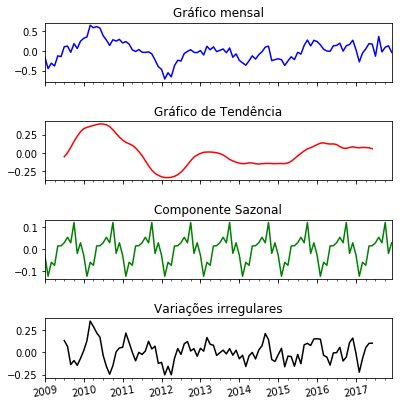

In [21]:
monta_grafico_de_decomposicao('anomalia_mensal')